# EVAC Assessment 1 - Evolve a Player for the Video Game Snake


## Setup
Imports the necessary third-party modules (deap, numpy etc.) as well as the custom written modules (game, network, genetic & visualization) to run the genetic algorithm & variant experiments

In [1]:
import numpy as np
import logging
import os
import pickle
from deap import tools
import warnings
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
%matplotlib inline

from game import DisplayGame, Snake, run_game
from network import generate_neural_net
from genetic import genetic_algorithm
from visualisation import plot_experiment
from enums import Experiment, ExperimentType

warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 20})

XSIZE = YSIZE = 16 # Number of grid cells in each direction (do not change this)
HEADLESS = True # True to run without graphical interface or False to run with the game showing
logging.basicConfig(level=logging.INFO) # Initializes the logging level used to output to console

if not HEADLESS:
    display = DisplayGame(XSIZE,YSIZE) # Initializes display if not running in headless mode

# Initializes game
snake_game = Snake(XSIZE,YSIZE)


analysis_gen_number = 150 
analysis_population_size = 1500 
final_gen_number = 200
final_population_size = 1500
test_gen_number = 50
test_population_size = 200

## Experiment Code
Functions to run the genetic algorithm to perform the different experiments. 

In [2]:
def run_test_experiment(gen_num, pop_num):
    '''Simple function to run final algorithm once and plot mean/max fitness against generation'''
    ind_size, network = generate_neural_net("b")
    logbook, _ = genetic_algorithm(ind_size, network, snake_game, display, HEADLESS, gen_num, pop_num, mut_prob=0.021, cx_prob=0.3, exp_type=Experiment.TEST, algorithm="b")

    fig = plt.figure(figsize =(10, 7)) 
    ax = fig.add_axes([0, 0, 1, 1]) 
    ax.set_xlabel('Generation')
    ax.set_ylabel('Fitness')
    ax.plot(logbook.select("gen"), logbook.select("mean"), lw=3, color='blue')
    ax.plot(logbook.select("gen"), logbook.select("max"), lw=3, color='orange')
    plt.legend(["Mean", "Max"], bbox_to_anchor=(0.75, 1.15), ncol=2)


### Mutation & Crossover Probability Experiment
Number of generations = 150
Population size = 1500
- Exploration
  - Runs the algorithm for 16 different probability pairings for mutation/crossover (provided in report appendix)
  - Each algorithm is ran 5 times and then the statistics are averaged (due to the stochastic nature of genetic algorithms)
- Final
  - Runs the algorithm for the 2 best probability pairings
  - Each algorithm is ran 15 times and then the statistics are averaged (due to the stochastic nature of genetic algorithms)

In [3]:
def run_cxindpb_experiment(gen_number, population_size, exp_type):
    '''Runs the mutation/crossover probability experiment (exploration or final) and outputs data to folder'''

    # Initialises the neural network and individual size with the default algorithm
    ind_size, network = generate_neural_net("b")
    
    # Deletes existing folder and old run info
    save_loc = f"sim-outputs//cx-indpb-{exp_type.value}-experiment"
    if os.path.exists(save_loc):
        logging.info("Found old folder for experiment - please save or delete")
        return

    if exp_type == ExperimentType.EXPLORATION:
        iteration_num = 5
        indpb_probs = np.arange(0.003, 0.021, 0.006)
        cx_probs = np.arange(0.1, 0.5, 0.1)
        probability_pairs = [(indpb, cx) for indpb in indpb_probs for cx in cx_probs]
    elif exp_type == ExperimentType.FINAL:
        iteration_num = 15
        probability_pairs = [(0.021, 0.3), (0.015, 0.3)]

    count = 1
    logging.info(f"STARTING CX-INDPB {exp_type.value.upper()} EXPERIMENT")
    for iteration in range(1, iteration_num + 1):
        for indpb, cx in probability_pairs:
            logging.info(f"Running algorithm for indpb {indpb} and cx {cx} - iteration {iteration}/{iteration_num} - overall completion {count}/{len(probability_pairs) * iteration_num}")
            genetic_algorithm(ind_size, network, snake_game, display, HEADLESS, gen_number, population_size, mut_prob=indpb, cx_prob=cx, exp=Experiment.CXINDPB, exp_type=exp_type)
            logging.info("> Run complete")
            count += 1
    logging.info(f"CX-INDPB {exp_type.value.upper()} EXPERIMENT COMPLETE")

### Neural Network Input Experiment
Number of generations = 150

Population size = 1500

- Exploration
  - Runs the algorithm for the 8 different combinations of neural network inputs (provided in report appendix)
  - Each algorithm is ran 5 times and then the statistics are averaged (due to the stochastic nature of genetic algorithms)
- Final
  - Runs the algorithm for the 2 best combinations of inputs
  - Each algorithm is ran 15 times and then the statistics are averaged (due to the stochastic nature of genetic algorithms).

In [4]:
def run_input_experiment(gen_number, population_size, exp_type):
    # Deletes existing folder and old run info
    save_loc = f"sim-outputs//input-{exp_type.value}-experiment"
    if os.path.exists(save_loc):
        logging.info("Found old folder for experiment - please save or delete")
        return
    
    if exp_type == ExperimentType.EXPLORATION:
        iteration_num = 5
        algorithms = ["a", "b", "c", "d", "e", "f", "g", "h"]
    elif exp_type == ExperimentType.FINAL:
        iteration_num = 15
        algorithms = ["b", "d"]
    
    count = 1
    logging.info(f"STARTING INPUT {exp_type.value.upper()} EXPERIMENT")
    for iteration in range(1, iteration_num + 1):
        for algorithm in algorithms:
            ind_size, network = generate_neural_net(algorithm)
            logging.info(f"Running algorithm {algorithm.upper()} - iteration {iteration}/{iteration_num} - overall completion {count}/{len(algorithms) * iteration_num}")
            genetic_algorithm(ind_size, network, snake_game, display, HEADLESS, gen_number, population_size,  mut_prob=0.021, cx_prob=0.3, exp = Experiment.INPUT, exp_type=exp_type, algorithm=algorithm)
            logging.info("> Run complete")
            count += 1
    logging.info(f"INPUT {exp_type.value.upper()} EXPERIMENT COMPLETE")

### Final Algorithm
Number of generations = 250

Population size = 1500

- Runs the algorithm with the best probability pair and best neural network inputs as previously identified.
- The algorithm is ran 15 times and then the statistics are averaged (due to the stochastic nature of genetic algorithms).

In [5]:
def run_final_algorithm(gen_number, population_size):
    algorithm = "b"
    mutation_prob = 0.021
    crossover_prob = 0.3
    iteration_num = 15

    # Deletes existing folder and old run info
    save_loc = f"sim-outputs//final-algorithm"
    if os.path.exists(save_loc):
        logging.info("Found old folder for experiment - please save or delete")
        return
    
    count = 1
    logging.info(f"RUNNING FINAL ALGORITHM")
    for iteration in range(1, iteration_num + 1):
        ind_size, network = generate_neural_net(algorithm)
        logging.info(f"Running final algorithm - iteration {iteration}/{iteration_num}")
        genetic_algorithm(ind_size, network, snake_game, display, HEADLESS, gen_number, population_size,  mut_prob=mutation_prob, cx_prob=crossover_prob, exp=Experiment.FINAL_ALGORITHM, exp_type=ExperimentType.FINAL_ALGORITHM, algorithm=algorithm)
        logging.info("> Run complete")
        count += 1
    logging.info(f"FINISHED RUNNING FINAL ALGORITHM")

def run_best_ind():
    '''Runs the game in non-headless using the best individual from the final algorithm'''
    save_location = "sim-outputs//final-algorithm"
    display = DisplayGame(XSIZE,YSIZE)
    _, network = generate_neural_net("b")

    max_fitness = 0
    max_fitness_individual = None
    runs = [folder for folder in os.listdir(save_location) if os.path.isdir(save_location + "//" + folder)]
    for run in runs:
        logbook_file = open(save_location + "//" + run + "//" + "logbook" + ".pkl", "rb")
        logbook = pickle.load(logbook_file)
        if logbook.select("max")[-1] > max_fitness:
            pop_file = open(save_location + "//" + run + "//" + "final_population" + ".pkl", "rb")
            max_fitness_individual = tools.selBest(pickle.load(pop_file), 1)[0]
            pop_file.close()
            max_fitness = logbook.select("max")[-1]

    network.setWeightsLinear(max_fitness_individual)
    print(f"Running individual with highest fitness of {max_fitness})")
    run_game(display, snake_game, False, network, "b")

## Statistics
Calculates the U and p values from a Mann Whitney U test on the final distributions of the two experiments. 

In [6]:
def compare_final_distributions(experiment):
    '''Calculates the U and p value for the two final distributions for either experiment (input or probability)'''
    
    save_location = "sim-outputs//"
    if experiment == Experiment.INPUT:
        save_location += "input-final-experiment"
    elif experiment == Experiment.CXINDPB:
        save_location += "cx-indpb-final-experiment"
    
    final_generation_file = open(save_location + "//" + "final_generation_averages" + ".pkl", "rb")
    final_distribution_data = pickle.load(final_generation_file)
    final_generation_file.close()

    data_a = final_distribution_data[0][1]
    data_b = final_distribution_data[1][1]

    data_a_size = len(data_a)
    data_b_size = len(data_b)

    max_u_size = data_a_size * data_b_size

    U, p = mannwhitneyu(data_a, data_b)

    print("----------------------------------------------")
    print(f"Final {experiment.value.capitalize()} Experiment Mann Whitney U Test:")
    print(f"U={U: .3f}")
    print(f"'U={max_u_size - U: .3f}")
    print(f"p={p: .3f}")
    print(f"Sample sizes: {data_a_size} & {data_b_size}")
    print(f"Max U value= {max_u_size}")
    print("----------------------------------------------")

## Running the Algorithm
### Test (for marking the assessment)
Runs and plots the mean fitness and max fitness of the final algorithm after 1 iteration for the given generation and population numbers.

INFO:root:Running generation 0/50
INFO:root:Running generation 1/50
INFO:root:Running generation 2/50
INFO:root:Running generation 3/50
INFO:root:Running generation 4/50
INFO:root:Running generation 5/50
INFO:root:Running generation 6/50
INFO:root:Running generation 7/50
INFO:root:Running generation 8/50
INFO:root:Running generation 9/50
INFO:root:Running generation 10/50
INFO:root:Running generation 11/50
INFO:root:Running generation 12/50
INFO:root:Running generation 13/50
INFO:root:Running generation 14/50
INFO:root:Running generation 15/50
INFO:root:Running generation 16/50
INFO:root:Running generation 17/50
INFO:root:Running generation 18/50
INFO:root:Running generation 19/50
INFO:root:Running generation 20/50
INFO:root:Running generation 21/50
INFO:root:Running generation 22/50
INFO:root:Running generation 23/50
INFO:root:Running generation 24/50
INFO:root:Running generation 25/50
INFO:root:Running generation 26/50
INFO:root:Running generation 27/50
INFO:root:Running generation 2

[{'gen': 0,
  'mean': 0.025,
  'std': 0.15612494995995996,
  'median': 0.0,
  'min': 0.0,
  'max': 1.0},
 {'gen': 1,
  'mean': 0.02,
  'std': 0.13999999999999999,
  'median': 0.0,
  'min': 0.0,
  'max': 1.0},
 {'gen': 2,
  'mean': 0.05,
  'std': 0.21794494717703364,
  'median': 0.0,
  'min': 0.0,
  'max': 1.0},
 {'gen': 3,
  'mean': 0.035,
  'std': 0.18377975949489103,
  'median': 0.0,
  'min': 0.0,
  'max': 1.0},
 {'gen': 4,
  'mean': 0.115,
  'std': 0.3343276835680827,
  'median': 0.0,
  'min': 0.0,
  'max': 2.0},
 {'gen': 5,
  'mean': 0.135,
  'std': 0.36983104250454696,
  'median': 0.0,
  'min': 0.0,
  'max': 2.0},
 {'gen': 6,
  'mean': 0.095,
  'std': 0.30979832149319336,
  'median': 0.0,
  'min': 0.0,
  'max': 2.0},
 {'gen': 7,
  'mean': 0.09,
  'std': 0.30315012782448236,
  'median': 0.0,
  'min': 0.0,
  'max': 2.0},
 {'gen': 8,
  'mean': 0.1,
  'std': 0.33166247903553997,
  'median': 0.0,
  'min': 0.0,
  'max': 2.0},
 {'gen': 9,
  'mean': 0.145,
  'std': 0.352100837829165,
  'm

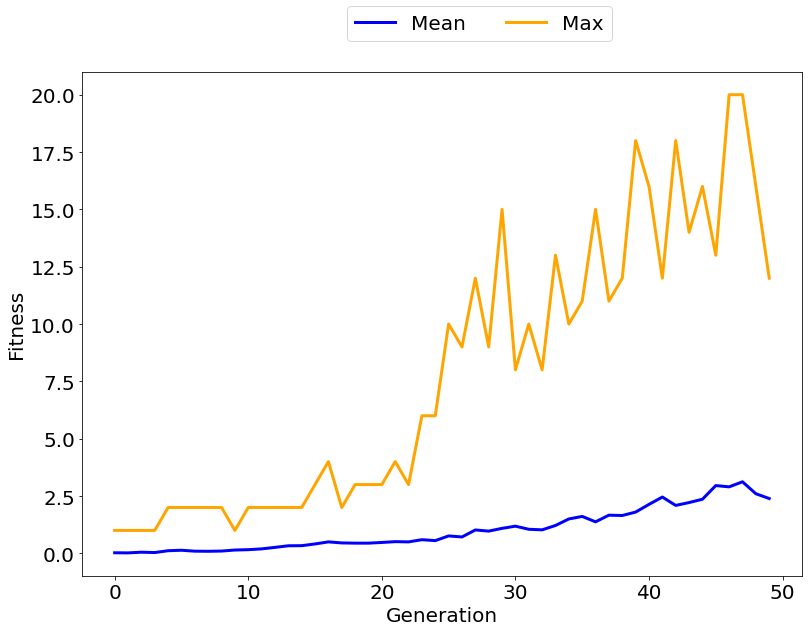

In [7]:
run_test_experiment(test_gen_number, test_population_size)



### Experiments
Runs and plots the experiments using the custom module `visualisation.py` that is provided.

In [8]:
# run_cxindpb_experiment(analysis_gen_number, analysis_population_size, ExperimentType.EXPLORATION)
# run_cxindpb_experiment(analysis_gen_number, analysis_population_size, ExperimentType.FINAL)
# plot_experiment(Experiment.CXINDPB, ExperimentType.EXPLORATION)
# plot_experiment(Experiment.CXINDPB, ExperimentType.FINAL)


In [9]:
# run_input_experiment(analysis_gen_number, analysis_population_size, ExperimentType.EXPLORATION)
# run_input_experiment(analysis_gen_number, analysis_population_size, ExperimentType.FINAL)
# plot_experiment(Experiment.INPUT, ExperimentType.EXPLORATION)
# plot_experiment(Experiment.INPUT, ExperimentType.FINAL)

In [10]:
# run_final_algorithm(final_gen_number, final_population_size)
# plot_experiment(Experiment.FINAL_ALGORITHM, ExperimentType.FINAL_ALGORITHM)
# run_best_ind()

## Statistics
Runs the Mann Whitney U function for both the input and probability experiments.

In [11]:
# compare_final_distributions(Experiment.INPUT)
# compare_final_distributions(Experiment.CXINDPB)